### Code working but root function dosen't return correct solutions
Daniel und RUbens Ableitung -1 für I <= 0 oder so

In [12]:
from scipy.optimize import root
from numba import njit
import numpy as np
from scipy.linalg import eigvals
from scipy.linalg import eigh
import sympy as sp
import matplotlib.pyplot as plt


In [13]:
print(sp.__version__)

1.10.1


# Setup
## Paramters

In [14]:
l = 1
beta0 = 0.5 #days^-1
gamma = 0.1 #days^-1
nu = 1/100 #days^-1
T_range = np.linspace(1,80, num = 150)
p_base_range = np.linspace(0.01, 0.35, num=150)


p_cap = 1e-3
epsilon = 1e-4
s = 0. # seasonal forcing
omega = 2 * np.pi / 360 #days⁻1

maxVax = 0.01 # Von N0 können pro tag geimpft werden

p_vax = 1000 # Zahl der Leute(*), die angst haben und sich deswegen Impfen lassen wollen
mu_im = 1/14 #1/days

## Defining Ode

In [15]:
# important functions for ODE

def vax(H, params):
    T, p_base = params
    return (1- np.exp(-p_vax*H))* maxVax


def P(H, params):
    T, p_base = params
    return p_base + (1-p_base)/p_cap * epsilon * np.log(1+np.exp(1/epsilon * (p_cap - H)))

In [16]:
# new SIR Ode
def dS(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return - beta0 * P(H, params) * I * S + nu * (R+V) - vax(H, params) * S

def dV1(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return vax(H, params) * S - V1 * mu_im - beta0 * P(H, params)* I * V1

def dV(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return V1 * mu_im - nu * V

def dI(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return beta0 * P(H, params) * I * (S+V1) - gamma * I

def dR(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return gamma*I - nu*R


def dH_1(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return 2/T * (I - H_1)

def dH(S, V1, V, I, R, H_1, H, params):
    T, p_base = params
    return 2/T * (H_1 - H)


def f(x, params):
    T, p_base = params
    (S, V1, V, I, R, H_1, H) = x
    return [dS(S, V1, V, I, R, H_1, H, params), 
            dV1(S, V1, V, I, R, H_1, H, params), 
            dV(S, V1, V, I, R, H_1, H, params), 
            dI(S, V1, V, I, R, H_1, H, params),
            dR(S, V1, V, I, R, H_1, H, params),
            dH_1(S, V1, V, I, R, H_1, H, params),
            dH(S, V1, V, I, R, H_1, H, params),
           ]

## Defining Jacobian and useful functions

In [17]:
#consider renaming all varibles that are symbols

#important functions: for how many vacinate, reaction to fear
def fvax(p_cap=p_cap, epsilon=epsilon):
    return sp.sympify( f"(1- exp(-{p_vax}*H_sym))* {maxVax}" )

def fP(p_cap=p_cap, epsilon=epsilon):
    return sp.sympify(f"p_0_sym + (1-p_0_sym)/{p_cap} * {epsilon} * log(1 + exp(1/{epsilon} * ({p_cap} - H_sym)))")


#ODE for sympy
def fS(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
    return - beta0 * fP() * I * S + nu * (R+V) - fvax() * S

def fV1(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
    return fvax() * S - V1 * mu_im - beta0 * fP() * I * V1

def fV(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
    return V1 * mu_im - nu * V

def fI(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
    return beta0 * fP() * I * (S+V1) - gamma * I

def fR(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
    return gamma*I - nu*R

def fH_1(S, V1, V, I, R, H_1, H, T, beta0=beta0, nu=nu): # Achtung hier ist auch T eine Varible
    return 2/T * (I - H_1)

def fH(S, V1, V, I, R, H_1, H, T, beta0=beta0, nu=nu): # Achtung hier ist auch T eine Varible
    return 2/T * (H_1 - H)


#def fH_1(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
#    return sp.sympify(f"2/T * (I - H_1)")

#def fH(S, V1, V, I, R, H_1, H, beta0=beta0, nu=nu):
#    return sp.sympify(f"2/T * (H_1 - H)")




# from ODE make jacobian
def getJac():
    """Return function of jacobian.
    
    provides
    ------
    params: <tuple>
            p_base: magic number
            T: magic number 
    
    """    
    x = sp.sympify("S_sym, V1_sym, V_sym, I_sym, R_sym, H_1_sym, H_sym")   # sympy-fy so derivative can be made
    params = sp.sympify("T_sym, p_0_sym")                                    #Wichtig Reihenfolge von params
    
    Mat = sp.Matrix([fS(*x), fV1(*x), fV(*x), fI(*x), fR(*x), fH_1(*x, *params), fH(*x, *params)])     # ODE into Matrix 
    # not sure if list conversion from tuple neccesary
    jac = Mat.jacobian(list(x))                            # make jacobian
    return sp.lambdify(list(x)+list(params), jac, modules="numpy") #make jacobian into numpy
    print(list(x))




In [18]:
# calculates Jacobian and makes function that enables putting in values so loops aren't overwehlmed
jacobian = getJac()
def jac_wv2(x, params):
    return jacobian(x[0], x[1], x[2], x[3], x[4], x[5], x[6], params[0], params[1])


In [19]:
# caclculate real eigenvalues of matrix
def largestEW(jac):
    EW = eigvals(jac)
    return np.max(EW.real)


# The Calculations

#### ODE in Abhänngigkeit von I

def dI_I(I, params):
    p_base, T = params
    H = I
    S = - gamma * I / (mu_im + beta0 * P(I, params) * I + vax(I, params))
    V1 = ((beta0 * P(I, params) *I +vax(I, params)) * S - gamma *I)/mu_im 
    return (beta0 * P(H, params) * (S+V1) - gamma) * I 


p = 0.03
T = 40
I0 = 0.1
root(dI_I, I0,  args = ((T, p),))

##### ODE in Abhänngigkeit von I mit Katharinas Umformungen dS, dV, dV1 = 0 gesetzt

def dI_I(I, params):
    H = I
    p_base, T = params
    a =( beta0 * P(H, params) * I + vax(H, params))
    b = ( mu_im + beta0 * P(H, params) *I )
    

    R = gamma / nu * I
    S = a * nu /( 1 - a * mu_im * b) * R
    V1 = b * S
    V = mu_im / nu *V1
    return (beta0 * P(H, params) * (S+V1) - gamma) * I 


p = 0.03
T = 40
I0 = 0.01
root(dI_I, I0,  args = ((T, p),))


## Solving 1D DGL of dI ~ I

/tmp/ipykernel_1313/1586179644.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  a = nu / (k * I + vax(H, params))
/tmp/ipykernel_1313/1586179644.py:43: RuntimeWarning: invalid value encountered in double_scalars
  S_I = a * ( 1 - I) / ( 1 + a + a*b)


    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([1.43848387e-34])
       r: array([-0.4000022])
  status: 1
 success: True
       x: array([0.])

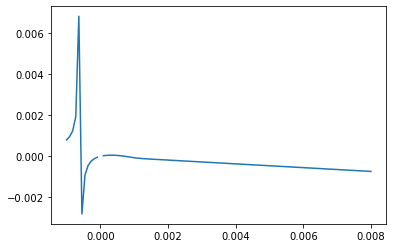

In [20]:
# ODE in Abhänngigkeit von I mit Umformungen nicht dR = 0

def give_SVIR(I, params): 
    # for given I returns valus of S, V1, V R
    H = I
    a = ( beta0 * P(H, params) * I + vax(H, params))
    b = ( mu_im + beta0 * P(H, params) *I )
    S_I  = nu * ( 1 - I ) / ( a + nu + nu/b * vax(I, params))
    V1_I = 1/b * vax(H, params) *S_I
    V_I  = mu_im / nu * V1_I
    R_I  = 1 - S_I - V1_I - V_I - I
    H_1_I = I
    H_I   = I
    return [S_I, V1_I, V_I, I, R_I, H_1_I, H_I]

def dI_I(I, params): #Ode dI/dt only ~ I
    H = I
    T, p_base = params
    a = ( beta0 * P(H, params) * I + vax(H, params))
    b = ( mu_im + beta0 * P(H, params) *I )
    S = nu * ( 1 - I ) / ( a + nu + nu/b * vax(H, params))
    V1 = 1/b * vax(H, params) * S
    return (beta0 * P(H, params) * (S+V1) - gamma) * I 

def dI_I2(I, params): #Ode dI/dt only ~ I
    T, p_base = params
    H = I
    k = beta0 * P(H, params)
    S = nu * (R + V) / (k * I + vax(H, params))
    V = mu/nu * V1
    V1 = vax(H, params) * S / (mu_im + k *I)
    R = 1 - S- V1 - V - I
    return (beta0 * P(H, params) * (S_I+V1_I) - gamma) * I 


def dI_I3(I, params): #Ode dI/dt only ~ I
    T, p_base = params
    H = I
    k = beta0 * P(H, params)
    a = nu / (k * I + vax(H, params))
    b = vax(H, params) / ( mu_im + k * I)
    
    S_I = a * ( 1 - I) / ( 1 + a + a*b)
    V1_I = vax(H, params) * S_I / (mu_im + k *I)
    return (beta0 * P(H, params) * (S_I+V1_I) - gamma) * I 

#Daniel und Rubens dI
def dI_I4(I, params): 
    T, p_base = params
    S = (1-I)/(vax(I, params)/(mu_im+beta0*P(I, params)*I+nu)+ (beta0*P(I, params)*I)/nu -1)
    V1 = - S/nu *(beta0 * P(I, params)*I + vax(I, params)-nu) +1-I
    #if (I<= 0.0001):
    #    return -1 
    #else:
    return beta0 * P(I, params) * I * (S+V1) - gamma* I

# Daniel und Rubens dI mit I<= ... -> dI = -1
def dI_I5(I, params):
    T, p_base = params
    S = (1-I)/(vax(I, params)/(mu_im+beta0*P(I, params)*I+nu)+ (beta0*P(I, params)*I)/nu -1)
    V1 = - S/nu *(beta0 * P(I, params)*I + vax(I, params)-nu) +1-I
    if (I<= 0.00001):
        return -1 
    else:
        return beta0 * P(I, params) * I * (S+V1) - gamma* I

    
# Plot zum Anschauen:
params = (40, 0.03)
I = np.linspace(-0.001,0.001, 100)
I = np.linspace(-0.001,0.008, 100)

plt.plot(I, [dI_I3(i, params) for i in I])


p = 0.03
T = 40
I0 = 1
root(dI_I, I0,  args = ((T, p),))


In [27]:
# Erstelle Karte
karte = np.zeros((len(T_range), len(p_base_range)))

T_range = np.linspace(1,80, num =150)
p_base_range = np.linspace(0.01, 0.35, num = 150)

for m,p in enumerate(p_base_range):
    for n,T in enumerate(T_range):
        sol = root(dI_I4, I0,  args = ((T, p),))
        x = give_SVIR(I0, (T,p))
        karte[m,n] = largestEW(jac_wv2(x, (T,p)))

/tmp/ipykernel_1313/3048200097.py:10: RuntimeWarning: overflow encountered in exp
  return p_base + (1-p_base)/p_cap * epsilon * np.log(1+np.exp(1/epsilon * (p_cap - H)))
/tmp/ipykernel_1313/1586179644.py:51: RuntimeWarning: invalid value encountered in multiply
  V1 = - S/nu *(beta0 * P(I, params)*I + vax(I, params)-nu) +1-I


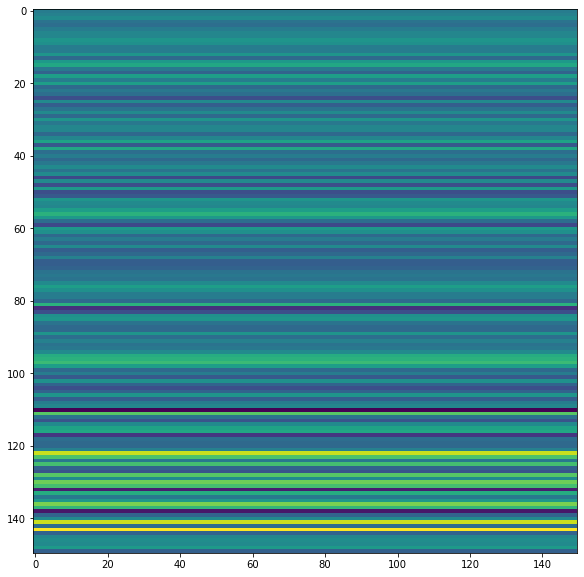

In [28]:

plt.figure(figsize=(10,10))
plt.imshow(karte)
#plt.savefig("thinner_stripes.pdf")

### Calculations mit Jacobi

In [12]:
S0 = 0.60
V10 = 0.05
V0 =  0.35
I0 = 0.003
R0 = 0.12
H_10 = I0
H0 = I0


x = [S0, V10, V0, I0, R0, H_10, H0]
p_base = 0.1
T = 100

# Berechne Jacobian und definiere wie Werte eingesetzt werden
jacobian = getJac()
def jac_wv2(x, params):
    return jacobian(x[0], x[1], x[2], x[3], x[4], x[5], x[6], params[0], params[1])

#root(f, x, jac=jac_wv2,  args = ((T, p),))

In [13]:
# Erstelle Karte
karte = np.zeros((len(T_range), len(p_base_range)))

# Lege Startvektor fest

S0 = 0.60
V10 = 0.05
V0 =  0.35
I0 = 0.003
R0 = 0.12
H_10 = I0
H0 = I0

x = [S0, V10, V0, I0, R0, H_10, H0]


# Berechne Jacobian und definiere wie Werte eingesetzt werden
jacobian = getJac()
def jac_wv2(x, params):
    return jacobian(x[0], x[1], x[2], x[3], x[4], x[5], x[6], params[0], params[1])

# Finde Nullstellen für verschiedene T, p_0 = p_base
for n,T in enumerate(T_range):
    for m,p in enumerate(p_base_range):
        sol = root(f, x, jac=jac_wv2, args = ((T, p),))
        #sol = root(f, x, args = ((T, p),))
        x = sol.x
        karte[n, m] = largestEW(jac_wv2(x, (T,p)))
        

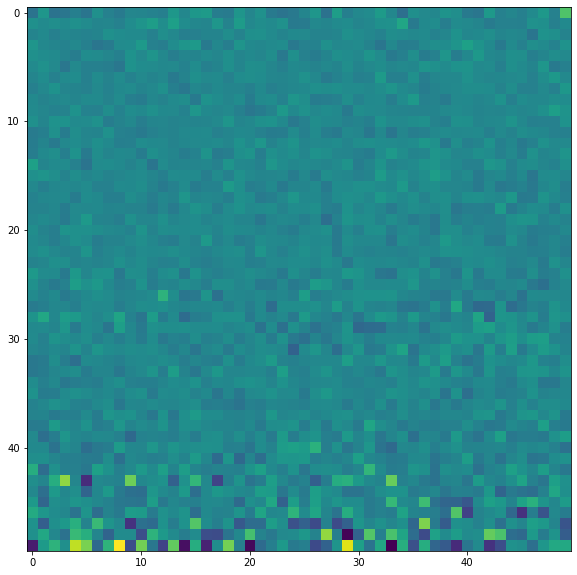

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(karte)